In [1]:
import networkx as nx
import matplotlib.pyplot as plt

## **1: Visualizar grafo**

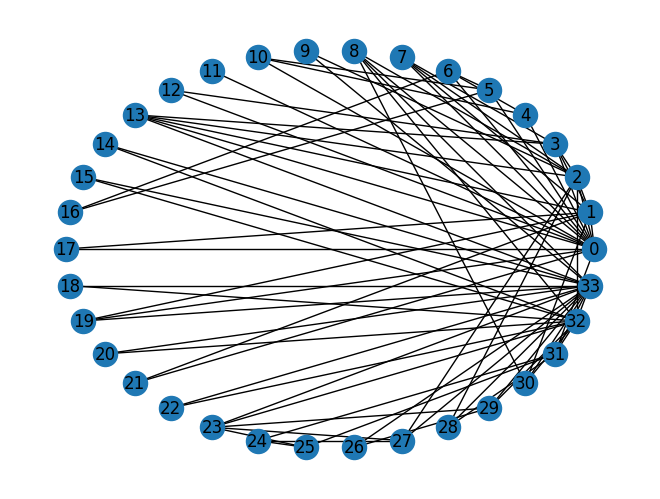

In [2]:
G = nx.karate_club_graph()
nx.draw_circular(G, with_labels=True)
plt.show()

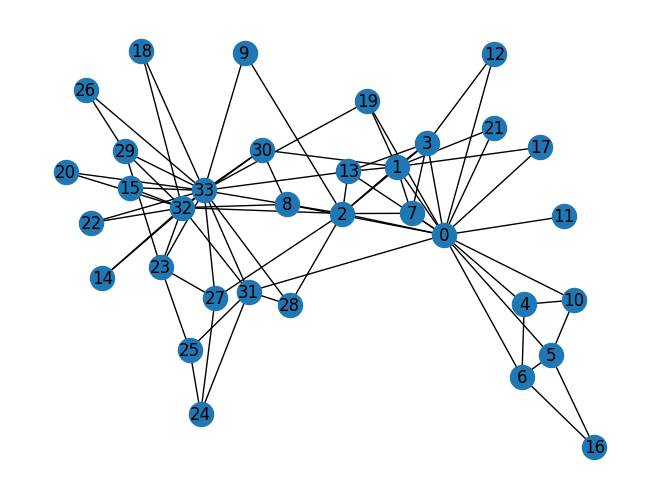

In [3]:
G: nx.classes.graph.Graph = nx.karate_club_graph()
nx.draw(G, with_labels=True)

In [4]:
G.nodes[0]["club"]

'Mr. Hi'

## **2: Louvain**

In [3]:
import networkx as nx
import community as community_louvain

# Cargar el grafo Karate Club
G: nx.classes.graph.Graph = nx.karate_club_graph()

# Detectar comunidades utilizando el algoritmo de Louvain
partition = community_louvain.best_partition(G)

# La modularidad se calcula con la partición obtenida
modularity_value = community_louvain.modularity(partition, G)

print(f"La modularidad Louvain es: {modularity_value}")

La modularidad Louvain es: 0.4276718952043627


## **3: Leiden**

In [4]:
import networkx as nx
import leidenalg
import igraph as ig

# Cargar el grafo Karate Club
G = nx.karate_club_graph()

# Convertir el grafo de NetworkX a un grafo de igraph (requerido por leidenalg)
G_igraph = ig.Graph.from_networkx(G)

# Aplicar el algoritmo de Leiden
partition = leidenalg.find_partition(G_igraph, leidenalg.ModularityVertexPartition)

# Obtener la modularidad
modularity_value = partition.modularity

print(f"La modularidad Leiden es: {modularity_value}")


La modularidad Leiden es: 0.41978961209730437


## **4: Dendrograma**

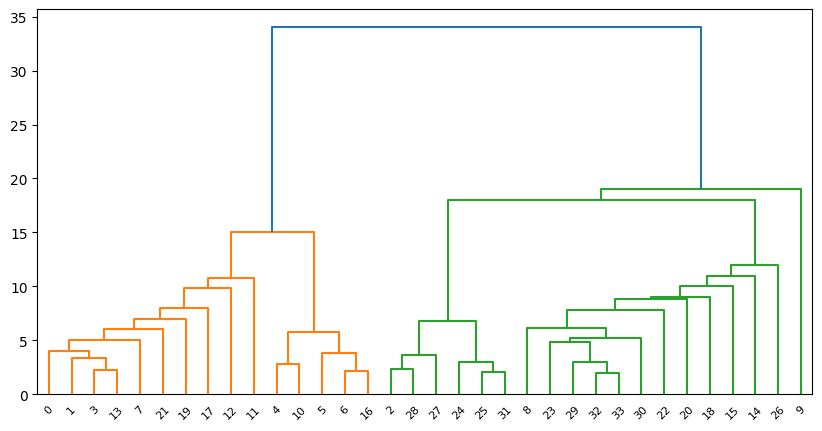

In [22]:
import networkx as nx
from itertools import chain, combinations
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram

# get simulated Graph() and Girvan-Newman communities list
G = nx.karate_club_graph()
communities = list(nx.community.girvan_newman(G))

# building initial dict of node_id to each possible subset:
node_id = 0
init_node2community_dict = {node_id: communities[0][0].union(communities[0][1])}
for comm in communities:
    for subset in list(comm):
        if subset not in init_node2community_dict.values():
            node_id += 1
            init_node2community_dict[node_id] = subset

# turning this dictionary to the desired format in @mdml's answer
node_id_to_children = {e: [] for e in init_node2community_dict.keys()}
for node_id1, node_id2 in combinations(init_node2community_dict.keys(), 2):
    for node_id_parent, group in init_node2community_dict.items():
        if len(init_node2community_dict[node_id1].intersection(init_node2community_dict[node_id2])) == 0 and group == init_node2community_dict[node_id1].union(init_node2community_dict[node_id2]):
            node_id_to_children[node_id_parent].append(node_id1)
            node_id_to_children[node_id_parent].append(node_id2)

# also recording node_labels dict for the correct label for dendrogram leaves
node_labels = dict()
for node_id, group in init_node2community_dict.items():
    if len(group) == 1:
        node_labels[node_id] = list(group)[0]
    else:
        node_labels[node_id] = ''

# also needing a subset to rank dict to later know within all k-length merges which came first
subset_rank_dict = dict()
rank = 0
for e in communities[::-1]:
    for p in list(e):
        if tuple(p) not in subset_rank_dict:
            subset_rank_dict[tuple(sorted(p))] = rank
            rank += 1
subset_rank_dict[tuple(sorted(chain.from_iterable(communities[-1])))] = rank

# my function to get a merge height so that it is unique (probably not that efficient)
def get_merge_height(sub):
    sub_tuple = tuple(sorted([node_labels[i] for i in sub]))
    n = len(sub_tuple)
    other_same_len_merges = {k: v for k, v in subset_rank_dict.items() if len(k) == n}
    min_rank, max_rank = min(other_same_len_merges.values()), max(other_same_len_merges.values())
    range = (max_rank-min_rank) if max_rank > min_rank else 1
    return float(len(sub)) + 0.8 * (subset_rank_dict[sub_tuple] - min_rank) / range

# finally using @mdml's magic, slightly modified:
G           = nx.DiGraph(node_id_to_children)
nodes       = G.nodes()
leaves      = set( n for n in nodes if G.out_degree(n) == 0 )
inner_nodes = [ n for n in nodes if G.out_degree(n) > 0 ]

# Compute the size of each subtree
subtree = dict( (n, [n]) for n in leaves )
for u in inner_nodes:
    children = set()
    node_list = list(node_id_to_children[u])
    while len(node_list) > 0:
        v = node_list.pop(0)
        children.add( v )
        node_list += node_id_to_children[v]
    subtree[u] = sorted(children & leaves)

inner_nodes.sort(key=lambda n: len(subtree[n])) # <-- order inner nodes ascending by subtree size, root is last

# Construct the linkage matrix
leaves = sorted(leaves)
index  = dict((tuple([n]), i) for i, n in enumerate(leaves))
Z = []
k = len(leaves)
for i, n in enumerate(inner_nodes):
    children = node_id_to_children[n]
    x = children[0]
    for y in children[1:]:
        z = tuple(sorted(subtree[x] + subtree[y]))
        i, j = index[tuple(sorted(subtree[x]))], index[tuple(sorted(subtree[y]))]
        Z.append([i, j, get_merge_height(subtree[n]), len(z)]) # <-- float is required by the dendrogram function
        index[z] = k
        subtree[z] = list(z)
        x = z
        k += 1

# dendrogram
plt.figure(figsize=(10,5))
dendrogram(Z, labels=[node_labels[node_id] for node_id in leaves])
plt.savefig('dendrogram.png')

## **5: Label Propagation & Clique Percolation**